<a href="https://colab.research.google.com/github/R3gm/SD_diffusers_interactive/blob/main/Stable_diffusion_interactive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion Interactive Notebook 📓 🤖

| Code Credits | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/R3gm/SD_diffusers_interactive?style=social)](https://github.com/R3gm/SD_diffusers_interactive) |
| Original Colab | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/redromnon/stable-diffusion-interactive-notebook/blob/main/stable_diffusion_interactive_notebook.ipynb) |




A widgets-based interactive notebook for Google Colab that lets users generate AI images from prompts (Text2Image) using [Stable Diffusion (by Stability AI, Runway & CompVis)](https://en.wikipedia.org/wiki/Stable_Diffusion).

This notebook aims to be an alternative to WebUIs while offering a simple and lightweight GUI for anyone to get started with Stable Diffusion.

Uses Stable Diffusion, [HuggingFace](https://huggingface.co/) Diffusers and [Jupyter widgets](https://github.com/jupyter-widgets/ipywidgets).

<br/>

Made with ❤️ by redromnon

[GitHub](https://github.com/redromnon/stable-diffusion-interactive-notebook)

In [ ]:
#@title 👇 Installing dependencies { display-mode: "form" }
#@markdown ---
#@markdown Make sure to select **GPU** as the runtime type:<br/>
#@markdown *Runtime->Change Runtime Type->Under Hardware accelerator, select GPU*
#@markdown
#@markdown ---

!pip install -q omegaconf==2.3.0 torch diffusers==0.20.2 transformers accelerate scipy safetensors==0.3.3 xformers mediapy ipywidgets==7.7.1
!apt install aria2

`RESTART THE RUNTIME` before executing the next cell.

In [16]:
#@title 👇 Download Model { form-width: "20%", display-mode: "form" }
#@markdown ---
#@markdown - **Download a Model** - Provide a link for Civitai api or Hugging Face safetensors file

import os
%cd /content
directory_path = 'models'
os.makedirs(directory_path, exist_ok=True)

download_link = "'https://civitai.com/api/download/models/125771'" # @param {type:"string"}
#@markdown
#@markdown ---

!aria2c --optimize-concurrent-downloads --console-log-level=error --summary-interval=10 -j5 -x16 -s16 -k1M -c -d {directory_path} -Z {download_link}

model_list = []

valid_extensions = {'.pth', '.safetensors', '.bin'}

for filename in os.listdir(directory_path):
    if os.path.splitext(filename)[1] in valid_extensions:
        name_without_extension = os.path.splitext(filename)[0]
        file_path = os.path.join(directory_path, filename)
        model_list.append((name_without_extension, file_path))
        print('FILE', name_without_extension, file_path)


Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
9e0490|OK  |       0B/s|models/toonyou_beta6.safetensors

Status Legend:
(OK):download completed.
FILE asdfasdf models/asdfasdf.txt
FILE toonyou_beta6 models/toonyou_beta6.safetensors


In [85]:
#@title 👇 Selecting Model { form-width: "20%", display-mode: "form" }
#@markdown ---
#@markdown - **Select Model** - A list of Stable Diffusion models to choose from.
#@markdown - **Safety Checker** - Enable/Disable uncensored content
#@markdown
#@markdown ---
%cd /content
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler, DDIMScheduler, EulerDiscreteScheduler, UniPCMultistepScheduler
from diffusers.models import AutoencoderKL
import torch
import ipywidgets as widgets
import importlib

#Enable third party widget support
from google.colab import output
output.enable_custom_widget_manager()

#Pipe
pipe = None

#Models
select_model = widgets.Dropdown(
    options=model_list,
    description="Select Model:"
)



#Safety Checker
safety_check = widgets.Checkbox(
    value=True,
    description="Enable Safety Check",
    layout=widgets.Layout(margin="0px 0px 0px -85px")
)

#Output
out = widgets.Output()

#Apply Settings
apply_btn = widgets.Button(
    description="Apply",
    button_style="info"
)


#Run pipeline
def pipeline(p):

  global pipe

  out.clear_output()
  apply_btn.disabled = True

  with out:

    print("Running, please wait...")
    print(select_model.value)

    pipe = StableDiffusionPipeline.from_single_file(
      select_model.value,
      #scheduler=get_scheduler(select_sampler.value),
      torch_dtype=torch.float16,
      #vae=AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
    ).to("cuda")

    if not safety_check.value:
      pipe.safety_checker = None

    pipe.enable_xformers_memory_efficient_attention()

    print("Finished!")

  apply_btn.disabled = False


#Display
apply_btn.on_click(pipeline)

widgets.VBox(
    [
      widgets.HTML(value="<h2>Configure Pipeline</h2>"),
      select_model, safety_check, apply_btn, out
    ]
)


/content


In [65]:
#@title 👇 Generating Images { form-width: "20%", display-mode: "form" }
#@markdown ---
#@markdown - **Prompt** - Description of the image
#@markdown - **Negative Prompt** - Things you don't want to see or ignore in the image
#@markdown - **Steps** - Number of denoising steps. Higher steps may lead to better results but takes longer time to generate the image. Default is `30`.
#@markdown - **CFG** - Guidance scale ranging from `0` to `20`. Lower values allow the AI to be more creative and less strict at following the prompt. Default is `7.5`.
#@markdown - **Select Sampler** - A list of schedulers to choose from. #@markdown - **Seed** - A random value that controls image generation. The same seed and prompt produce the same images. Set `-1` for using random seed values.
#@markdown ---
%cd /content
import ipywidgets as widgets, mediapy, random
import IPython.display
from diffusers import (
    DPMSolverMultistepScheduler,
    DPMSolverSinglestepScheduler,
    KDPM2DiscreteScheduler,
    KDPM2AncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    HeunDiscreteScheduler,
    LMSDiscreteScheduler,
    DDIMScheduler,
)

#Get scheduler
def get_scheduler(name):

  match name:

    case "DPM++ 2M":
      return DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

    case "DPM++ 2M Karras":
      return DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)

    case "DPM++ 2M SDE":
      return DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, algorithm_type="sde-dpmsolver++")

    case "DPM++ 2M SDE Karras":
      return DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")

    case "DPM++ SDE":
      return DPMSolverSinglestepScheduler.from_config(pipe.scheduler.config, )

    case "DPM++ SDE Karras":
      return DPMSolverSinglestepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)

    case "DPM2":
      return KDPM2DiscreteScheduler.from_config(pipe.scheduler.config, )

    case "DPM2 Karras":
      return KDPM2DiscreteScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)

    case "Euler":
      return EulerDiscreteScheduler.from_config(pipe.scheduler.config, )

    case "Euler a":
      return EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config, )

    case "Heun":
      return HeunDiscreteScheduler.from_config(pipe.scheduler.config, )

    case "LMS":
      return LMSDiscreteScheduler.from_config(pipe.scheduler.config, )

    case "LMS Karras":
      return LMSDiscreteScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)

    case "DDIMScheduler":
      return DDIMScheduler.from_config(pipe.scheduler.config)

#PARAMETER WIDGETS
width = "300px"

prompt = widgets.Textarea(
    value="",
    placeholder="Enter prompt",
    #description="Prompt:",
    rows=5,
    layout=widgets.Layout(width="600px")
)

neg_prompt = widgets.Textarea(
    value="",
    placeholder="Enter negative prompt",
    #description="Negative Prompt:",
    rows=5,
    layout=widgets.Layout(width="600px")
)

num_images = widgets.IntText(
    value=1,
    description="Images:",
    layout=widgets.Layout(width=width),
)

steps = widgets.IntText(
    value=30,
    description="Steps:",
    layout=widgets.Layout(width=width)
)

CFG = widgets.FloatText(
    value=7.5,
    description="CFG:",
    layout=widgets.Layout(width=width)
)
##♟️♟️♟️
#Schedulers
select_sampler = widgets.Dropdown(
    options=[
        "DPM++ 2M",
        "DPM++ 2M Karras",
        "DPM++ 2M SDE",
        "DPM++ 2M SDE Karras",
        "DPM++ SDE",
        "DPM++ SDE Karras",
        "DPM2",
        "DPM2 Karras",
        "Euler",
        "Euler a",
        "Heun",
        "LMS",
        "LMS Karras",
        "DDIMScheduler",
    ],
    description="Scheduler:"
)
select_sampler.style.description_width = "auto"


img_height = widgets.Dropdown(
    options=[('512px', 512), ('768px', 768), ('1024px', 1024)],
    value=512,
    description="Height:",
    layout=widgets.Layout(width=width)
)

img_width = widgets.Dropdown(
    options=[('512px', 512), ('768px', 768), ('1024px', 1024)],
    value=512,
    description="Width:",
    layout=widgets.Layout(width=width)
)

random_seed = widgets.IntText(
    value=-1,
    description="Seed:",
    layout=widgets.Layout(width=width),
    disabled=False
)

generate = widgets.Button(
    description="Generate",
    disabled=False,
    button_style="primary"
)

display_imgs = widgets.Output()


#RUN
def generate_img(i):

  #Clear output
  display_imgs.clear_output()
  generate.disabled = True

  #Calculate seed
  seed = random.randint(0, 2147483647) if random_seed.value == -1 else random_seed.value

  with display_imgs:

    print("Running...")

    pipe.scheduler = get_scheduler(select_sampler.value)

    images = pipe(
      prompt.value,
      height = img_height.value,
      width = img_width.value,
      num_inference_steps = steps.value,
      guidance_scale = CFG.value,
      num_images_per_prompt = num_images.value,
      negative_prompt = neg_prompt.value,
      generator = torch.Generator("cuda").manual_seed(seed),
    ).images
    mediapy.show_images(images)

    # Save img
    import re
    def slugify(text, replacement='_'):
        return re.sub(r'[\/:*?"<>|]', replacement, text)
    global image_list
    image_list = []
    directory_images = 'images'
    os.makedirs(directory_images, exist_ok=True)
    for idx, (image,prompt_i) in enumerate(zip(images, [prompt.value[:80]*num_images.value])):
        print(slugify(prompt_i))
        image_name = f'{slugify(prompt_i)}-{idx}.png'
        image_path = directory_images + '/' + image_name

        if os.path.exists(image_path):
            random_number = random.randint(1, 100000)
            image_name = f'{slugify(prompt_i)}-{idx} random_number{str(random_number)}.png'
            image_path = directory_images + '/' + image_name
        image.save(image_path)
        image_list.append(image_path)

    #print(pipe.scheduler)
    print(f"Seed:\n{seed}")

  generate.disabled = False

#Display
generate.on_click(generate_img)

widgets.VBox(
    [
      widgets.AppLayout(
        header=widgets.HTML(
            value="<h2>Stable Diffusion</h2>",
        ),
        left_sidebar=widgets.VBox(
            [num_images, steps, CFG, select_sampler, img_height, img_width, random_seed]
        ),
        center=widgets.VBox(
            [prompt, neg_prompt, generate]
        ),
        right_sidebar=None,
        footer=None
      ),
      display_imgs
    ]
)

/content


/content
Image 'asdfasdf-0 random_number8582.png' has been copied to '/content/CodeFormer/inputs/user_upload/asdfasdf-0 random_number8582.png'
/content/CodeFormer
Face detection model: retinaface_resnet50
Background upsampling: True, Face upsampling: False
[1/1] Processing: asdfasdf-0 random_number8582.png
	detect 1 faces

All results are saved in results/user_upload_0.7


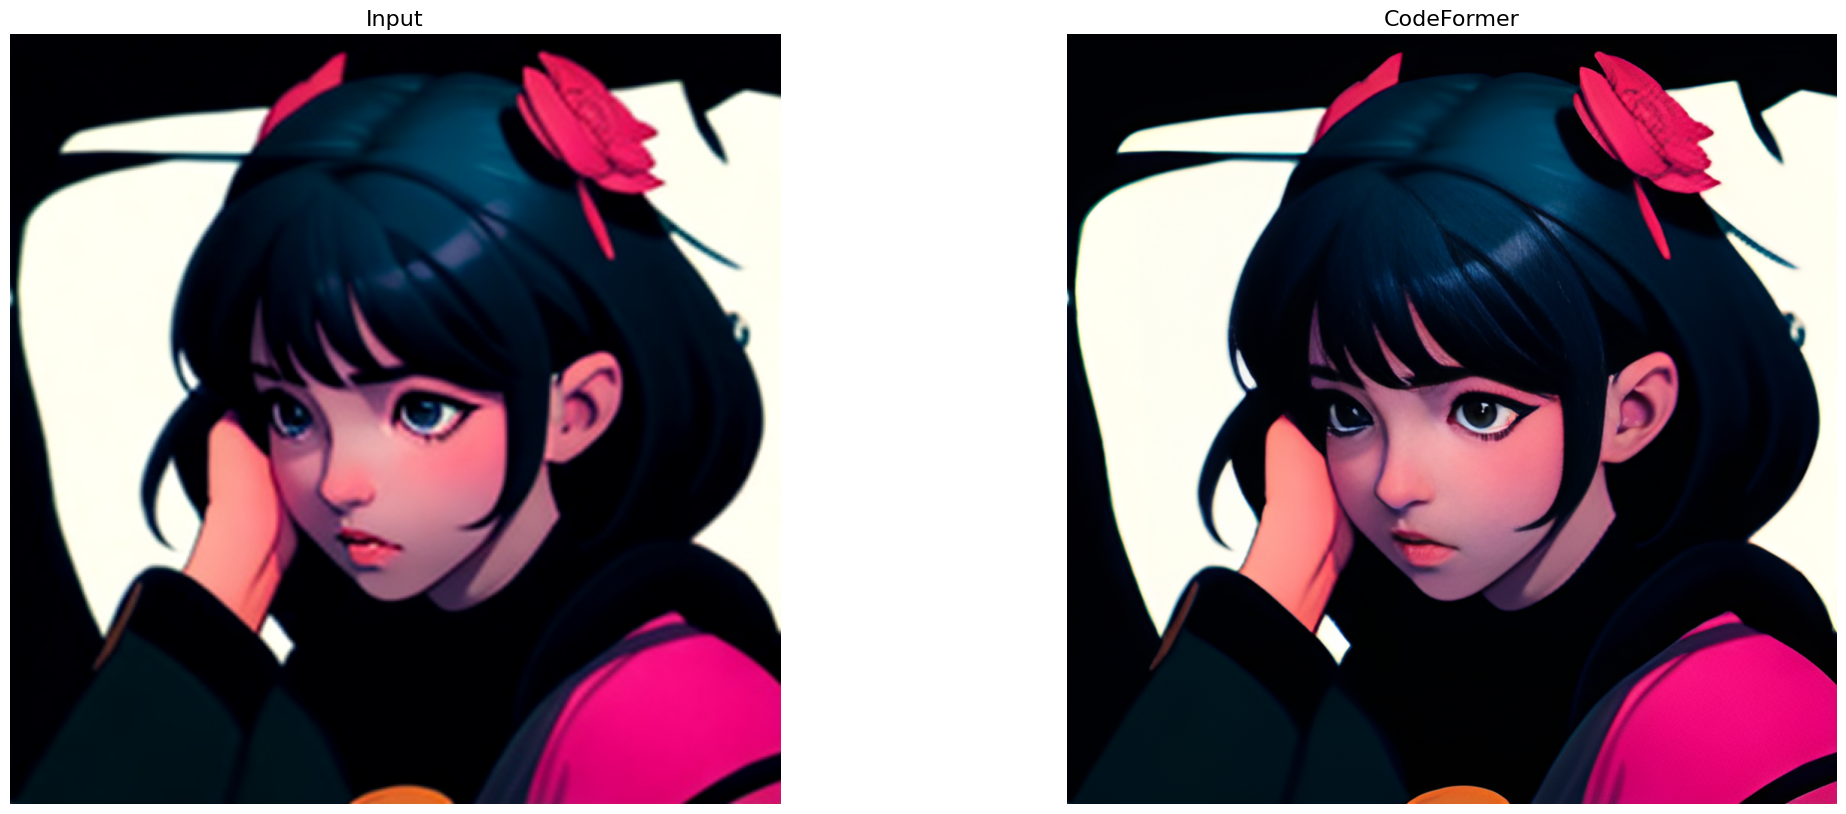

In [84]:
#@title 👇 Upscale and face restoration { form-width: "20%", display-mode: "form" }

import os
import shutil

%cd /content
directory_codeformer = '/content/CodeFormer/'
if not os.path.exists(directory_codeformer):
    os.makedirs(directory_codeformer)

    # Setup
    # Clone CodeFormer and enter the CodeFormer folder
    %cd /content
    !git clone https://github.com/sczhou/CodeFormer.git
    %cd CodeFormer


    # Set up the environment
    # Install python dependencies
    !pip install -q -r requirements.txt
    !pip -q install ffmpeg
    # Install basicsr
    !python basicsr/setup.py develop

    # Download the pre-trained model
    !python scripts/download_pretrained_models.py facelib
    !python scripts/download_pretrained_models.py CodeFormer

# Visualization function
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('CodeFormer', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Copy imgs
destination_directory = '/content/CodeFormer/inputs/user_upload'
os.makedirs(destination_directory, exist_ok=True)
for image_path in image_list:
    image_filename = os.path.basename('/content/'+image_path)
    destination_path = os.path.join(destination_directory, image_filename)
    try:
        shutil.copyfile('/content/'+image_path, destination_path)
        print(f"Image '{image_filename}' has been copied to '{destination_path}'")
    except Exception as e:
        print(f"Failed to copy '{image_filename}' to '{destination_path}': {e}")

#@markdown `CODEFORMER_FIDELITY`: Balance the quality (lower number) and fidelity (higher number)<br>
# you can add '--bg_upsampler realesrgan' to enhance the background
CODEFORMER_FIDELITY = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown `BACKGROUND_ENHANCE`: Enhance background image with Real-ESRGAN<br>
BACKGROUND_ENHANCE = True #@param {type:"boolean"}
#@markdown `FACE_UPSAMPLE`: Upsample restored faces for high-resolution AI-created images<br>
FACE_UPSAMPLE = False #@param {type:"boolean"}
#@markdown `HAS_ALIGNED`: Input are cropped and aligned faces<br>
HAS_ALIGNED =  False #@param {type:"boolean"}
#@markdown `UPSCALE`: The final upsampling scale of the image. Default: 2<br>
UPSCALE = 3 #@param {type:"slider", min:2, max:8, step:1}
#@markdown `DETECTION_MODEL`: Face detector. Default: retinaface_resnet50<br>
DETECTION_MODEL = "retinaface_resnet50" #@param ["retinaface_resnet50", "retinaface_mobile0.25", "YOLOv5l", "YOLOv5n", "dlib"]
#@markdown `DRAW_BOX`: Draw the bounding box for the detected faces.
DRAW_BOX = False #@param {type:"boolean"}

BACKGROUND_ENHANCE = '--bg_upsampler realesrgan' if BACKGROUND_ENHANCE else ''
FACE_UPSAMPLE = '--face_upsample' if FACE_UPSAMPLE else ''
HAS_ALIGNED = '--has_aligned' if HAS_ALIGNED else ''
DRAW_BOX = '--draw_box' if DRAW_BOX else ''
%cd CodeFormer
!python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path {destination_directory} {BACKGROUND_ENHANCE} {FACE_UPSAMPLE} {HAS_ALIGNED} --upscale {UPSCALE} --detection_model {DETECTION_MODEL} {DRAW_BOX}


import os
import glob

input_folder = 'inputs/user_upload'
result_folder = f'results/user_upload_{CODEFORMER_FIDELITY}/final_results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  basename = os.path.splitext(os.path.basename(input_path))[0]
  output_path = os.path.join(result_folder, basename+'.png')
  img_output = imread(output_path)
  display(img_input, img_output)

In [83]:
#@title Download CodeFormer results
import os
from google.colab import files
import shutil

!ls results
print('Download results')
os.system(f'zip -r results.zip results/user_upload_{CODEFORMER_FIDELITY}/final_results')
try:
  files.download("results.zip")
except:
  files.download(f'/content/CodeFormer/results/{filename[:-4]}_{CODEFORMER_FIDELITY}/{filename}')

user_upload_0.7
Download results


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>